# FINAL PROJECT CIS 432
## Members
## 28 April 2022

# Table of Contents
1. [Modules](#modules)
    1. [Import Modules](#import-modules)
2. [ETL](#etl)
3. [Descriptive Analysis](#descriptive-analysis)
    1. [Descriptive Statistics](#descriptive-statistics)

# Modules
<a class='anchor' id='modules'></a>

## Import Modules
<a class='anchor' id='import-modules'></a>

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import colors
from string import ascii_letters
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator


# ETL
<a class='anchor' id='etl'></a>

In [2]:
df = pd.read_csv("heloc_dataset_v1.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   RiskPerformance                     10459 non-null  object
 1   ExternalRiskEstimate                10459 non-null  int64 
 2   MSinceOldestTradeOpen               10459 non-null  int64 
 3   MSinceMostRecentTradeOpen           10459 non-null  int64 
 4   AverageMInFile                      10459 non-null  int64 
 5   NumSatisfactoryTrades               10459 non-null  int64 
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64 
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64 
 8   PercentTradesNeverDelq              10459 non-null  int64 
 9   MSinceMostRecentDelq                10459 non-null  int64 
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64 
 11  MaxDelqEver                         10459 non-null  in

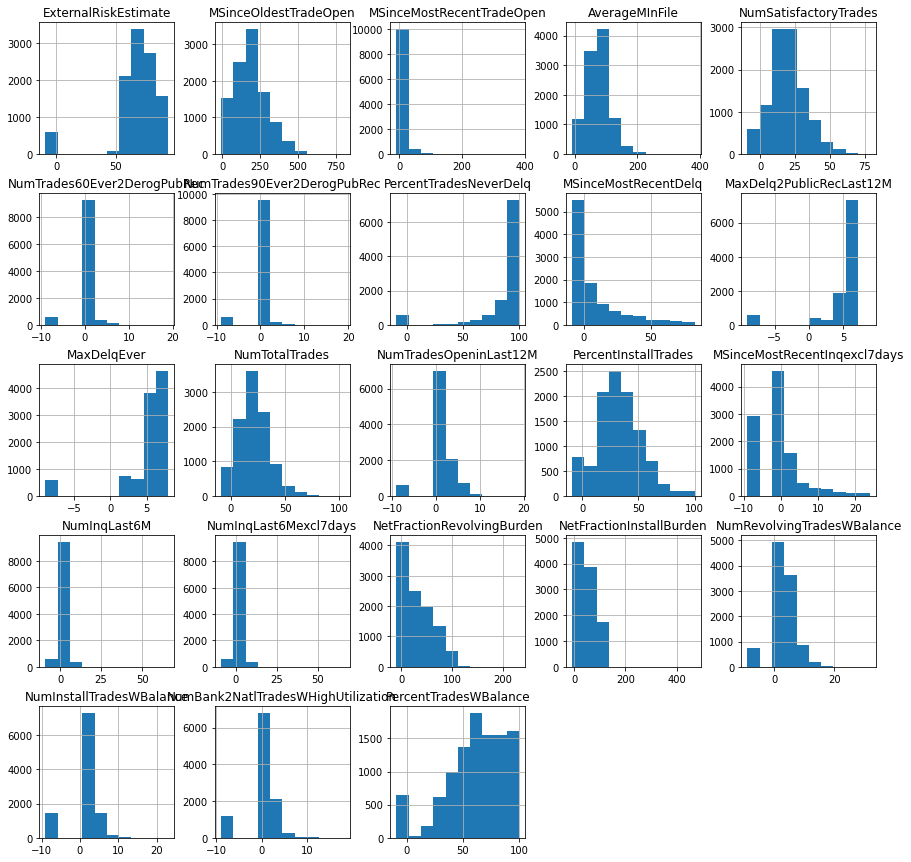

In [4]:
df.hist(figsize=(15,15));

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [5]:
df.describe()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,...,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000
mean,67.425758,184.205373,8.543455,73.843293,19.428052,0.042738,-0.142843,86.661536,6.762406,4.928291,...,32.166460,-0.325366,0.868152,0.812602,31.629888,39.158906,3.185008,0.976097,0.018071,62.079166
std,21.121621,109.683816,13.301745,38.782803,13.004327,2.513910,2.367397,25.999584,20.501250,3.756275,...,20.128634,6.067556,3.179304,3.143698,30.060140,42.101601,4.413173,4.060995,3.358135,27.711565
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,...,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,...,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,...,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,79.000000,249.500000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,...,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,9.000000,...,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


## Correlation Matrix
<a class='anchor' id='corr-matrix'></a>

Text(0.5, 1.0, 'Correlation Matrix')

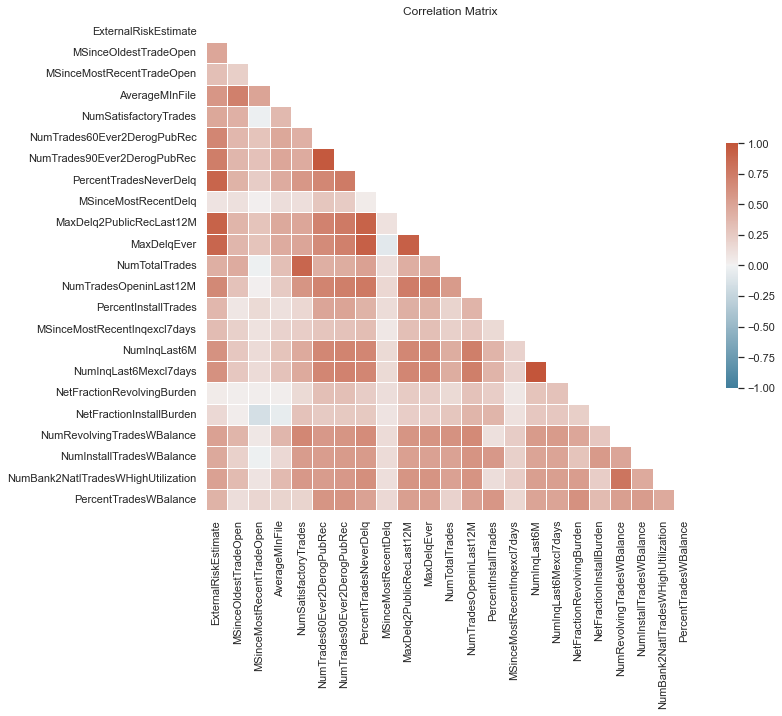

In [9]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix')

In [11]:
#Split varibles
X = df.iloc[:,1:24] #independent
Y = df.iloc[:,[0]].replace(to_replace=['Good', 'Bad'], value=[0, 1]).squeeze() #dependent

In [15]:
#Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [16]:
df_train = X_train.join(Y_train)

In [18]:
means = df_train.groupby(by = "ExternalRiskEstimate").mean()["RiskPerformance"]
means

ExternalRiskEstimate
-9     0.547826
 33    0.000000
 34    0.000000
 36    1.000000
 39    1.000000
 40    1.000000
 41    1.000000
 42    0.500000
 43    0.600000
 44    1.000000
 45    0.666667
 46    1.000000
 47    0.833333
 48    0.750000
 49    0.750000
 50    0.833333
 51    0.857143
 52    0.769231
 53    0.000000
 54    0.847059
 55    0.857143
 56    0.825806
 57    0.833333
 58    0.889655
 59    0.864583
 60    0.759563
 61    0.842593
 62    0.818653
 63    0.805654
 64    0.707627
 65    0.727273
 66    0.706897
 67    0.733032
 68    0.635417
 69    0.622568
 70    0.625899
 71    0.509615
 72    0.528620
 73    0.522184
 74    0.490385
 75    0.411067
 76    0.397321
 77    0.373391
 78    0.409091
 79    0.299578
 80    0.291667
 81    0.271429
 82    0.255924
 83    0.248619
 84    0.209877
 85    0.198864
 86    0.173913
 87    0.161491
 88    0.148148
 89    0.121212
 90    0.131579
 91    0.153846
 92    0.136364
 93    0.200000
 94    1.000000
Name: RiskPerforman

In [19]:
counts =df_train.groupby(by ="ExternalRiskEstimate").count()["RiskPerformance"]
counts

ExternalRiskEstimate
-9     460
 33      1
 34      1
 36      2
 39      1
 40      1
 41      1
 42      2
 43      5
 44      3
 45      3
 46      1
 47      6
 48      4
 49      4
 50     12
 51      7
 52     13
 53      1
 54     85
 55     98
 56    155
 57    150
 58    145
 59    192
 60    183
 61    216
 62    193
 63    283
 64    236
 65    308
 66    290
 67    221
 68    288
 69    257
 70    278
 71    208
 72    297
 73    293
 74    208
 75    253
 76    224
 77    233
 78    198
 79    237
 80    240
 81    210
 82    211
 83    181
 84    243
 85    176
 86    207
 87    161
 88    162
 89    132
 90     76
 91     78
 92     22
 93     10
 94      1
Name: RiskPerformance, dtype: int64

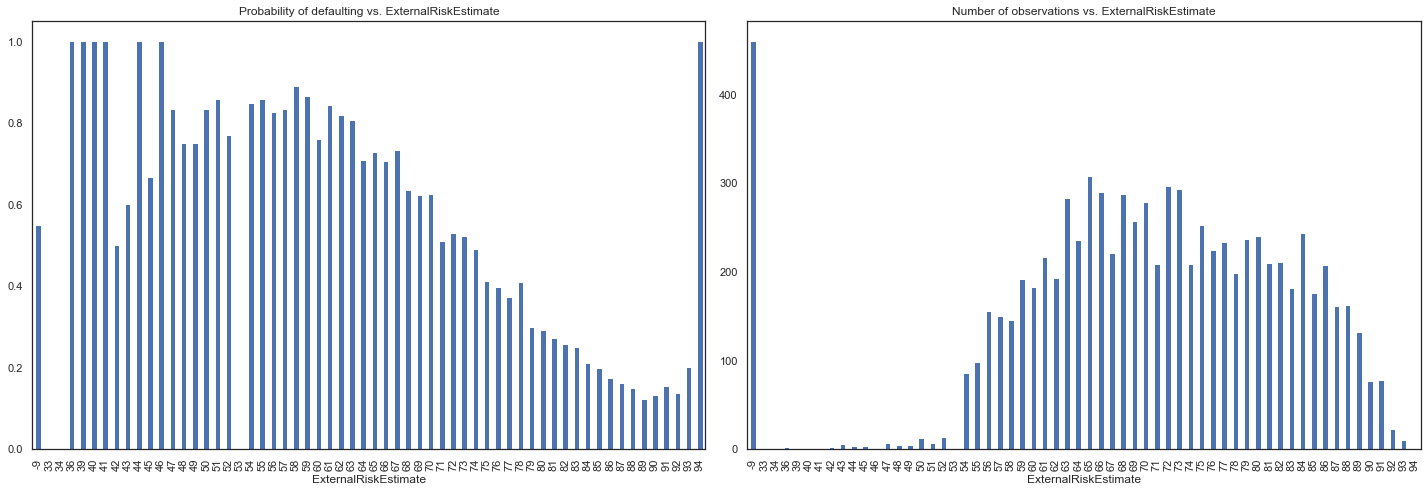

In [20]:
fig, axes = plt.subplots(1,2, figsize=(20,7))
means.plot.bar(ax=axes[0], title='Probability of defaulting vs. ExternalRiskEstimate')
counts.plot.bar(ax=axes[1], title='Number of observations vs. ExternalRiskEstimate')
plt.tight_layout()

In [21]:
#Merge again
df_train = X_train.join(Y_train)
df_test = X_test.join(Y_test)

#drop from merge
df_train = df_train.drop((df_train.loc[df['ExternalRiskEstimate']==-9]).index)
df_test = df_test.drop((df_test.loc[df['ExternalRiskEstimate']==-9]).index)

#Split XY in train
X_train = df_train.iloc[:,1:24]
Y_train = df_train.iloc[:,0]

#Split XY in test
X_test = df_test.iloc[:,1:24]
Y_test = df_test.iloc[:,0]

In [22]:
df_count_missing = pd.concat([(X_train==-7).sum(), (X_train==-8).sum(), (X_train==-9).sum()], axis=1)
df_count_missing.columns = [-7,-8,-9]
df_count_missing

,-7,-8,-9
MSinceOldestTradeOpen,0,201,0
MSinceMostRecentTradeOpen,0,0,0
AverageMInFile,0,0,0
NumSatisfactoryTrades,0,0,0
NumTrades60Ever2DerogPubRec,0,0,0
NumTrades90Ever2DerogPubRec,0,0,0
PercentTradesNeverDelq,0,0,0
MSinceMostRecentDelq,3740,137,0
MaxDelq2PublicRecLast12M,0,0,0
MaxDelqEver,0,0,0


Note: The next step is to handle the missing values and play with the imputer as we did in hw3. Once that is dones we can process with the training of different models